In [1]:
import sys

import numpy as np
import pandas as pd 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set_theme()
sns.set_style("whitegrid", {"grid.color": "0.9"})

linewidth = 0.5
params = {'font.family':'serif', 
          'font.serif':'Computer Modern',
          'text.usetex':True,
          'text.latex.preamble': r'\usepackage{amsfonts}',
          'figure.constrained_layout.use':True,
          'figure.figsize':(5, 4.624),
          'savefig.pad_inches':0.015,
          'axes.linewidth': linewidth,
          'grid.linewidth': linewidth,
          'xtick.major.pad': -2,
          'ytick.major.pad': -2}

plt.rcParams.update(params)

In [3]:
# Fix colors
SIZE_TWO_COLOR = 'darkgrey'
SIZE_THREE_COLOR = '#FFBC79'
SIZE_FOUR_COLOR = '#79BCFF'
hye_facecolor = {SIZE_TWO_COLOR: 'black', SIZE_THREE_COLOR: "#C85200", SIZE_FOUR_COLOR: "#006BA4"}

## Project "Higher-order data"

In [4]:
sys.path.append("../../../_Contributing/hgx/")
import hypergraphx
from hypergraphx import Hypergraph
from hypergraphx.readwrite.loaders import load_high_school
from hypergraphx.filters import get_svh
from hypergraphx.viz.draw_hypergraph import draw_hypergraph
from hypergraphx.representations.projections import clique_projection

##### Input data

In [5]:
H = load_high_school("../../../_Contributing/hgx/test_data/hs/hs.json", filter_by_class=['PC*'])
print(H)

Hypergraph with 39 nodes and 754 edges.
Distribution of hyperedge sizes: {2: 519, 3: 217, 4: 18}


In [6]:
# Get validated hyperedges
hs_svh = get_svh(H, mp=True)

# Filter hypergraph
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[-1]

edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)

[3.0771767141041745e-07]
61


##### Plot

In [7]:
hyperedge_color_by_order = {2: SIZE_THREE_COLOR, 3: SIZE_FOUR_COLOR}
hyeperedge_facecolor_by_order = {2: hye_facecolor[SIZE_THREE_COLOR], 3: hye_facecolor[SIZE_FOUR_COLOR]}

In [8]:
pos = nx.spring_layout(clique_projection(H2, keep_isolated=True),
                       iterations=120, seed=17, scale=1, k=0.75)
pos[214] = [0.17580071, 0.07780574]
pos[116] = [-0.02649419,  0.14016711]
pos[923] = [-0.50259044, -0.20990672]

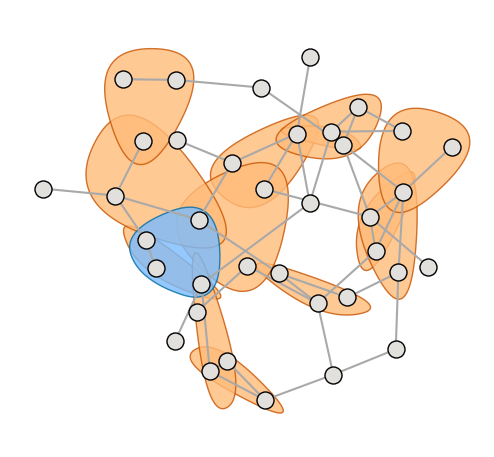

In [9]:
plt.subplot(1,1,1)
ax=plt.gca()

draw_hypergraph(
    H2, ax=ax, pos=pos,
    edge_width=1.5, edge_color=SIZE_TWO_COLOR, hyperedge_color_by_order=hyperedge_color_by_order, 
    hyperedge_facecolor_by_order=hyeperedge_facecolor_by_order, hyperedge_alpha=0.8,
    node_size=150, node_color='#E2E0DD', node_facecolor='black', node_shape='o', with_node_labels=False
)
sns.despine()
plt.savefig("img/project_2.jpg", dpi=600)